##**ENVIRONMENT SECTOR**

Epoch 1/200
45/55 [=======================>......] - ETA: 0s - loss: 10872.8877
Epoch 1: val_loss improved from inf to 6094.10498, saving model to best_model.h5
55/55 [==============================] - 2s 12ms/step - loss: 10162.0723 - val_loss: 6094.1050 - lr: 1.0000e-05
Epoch 2/200
28/55 [==============>...............] - ETA: 0s - loss: 4781.2422

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


49/55 [=========================>....] - ETA: 0s - loss: 3983.5686
Epoch 2: val_loss improved from 6094.10498 to 2009.67981, saving model to best_model.h5
55/55 [==============================] - 0s 7ms/step - loss: 3803.8582 - val_loss: 2009.6798 - lr: 1.0000e-05
Epoch 3/200
39/55 [====================>.........] - ETA: 0s - loss: 1335.5677
Epoch 3: val_loss improved from 2009.67981 to 517.48511, saving model to best_model.h5
55/55 [==============================] - 0s 5ms/step - loss: 1143.4845 - val_loss: 517.4851 - lr: 1.0000e-05
Epoch 4/200
47/55 [========================>.....] - ETA: 0s - loss: 292.4037
Epoch 4: val_loss improved from 517.48511 to 107.11948, saving model to best_model.h5
55/55 [==============================] - 0s 4ms/step - loss: 269.3848 - val_loss: 107.1195 - lr: 1.0000e-05
Epoch 5/200
46/55 [========================>.....] - ETA: 0s - loss: 57.2735
Epoch 5: val_loss improved from 107.11948 to 17.54171, saving model to best_model.h5
55/55 [===================

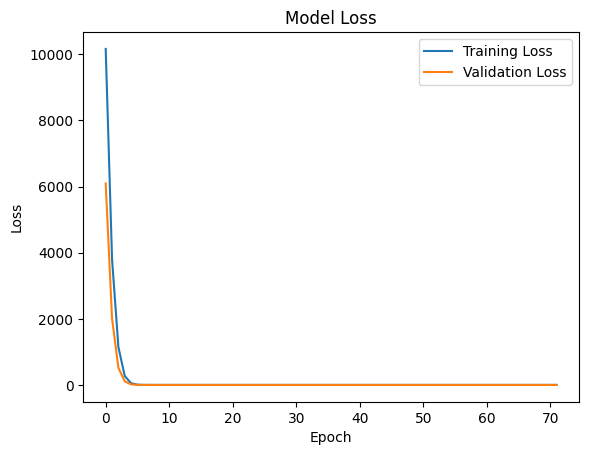

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def find_best_k(X, y):
    best_k = None
    best_score = -np.inf
    for k in range(1, X.shape[1] + 1):
        selector = SelectKBest(score_func=f_regression, k=k)
        X_selected = selector.fit_transform(X, y)
        score = np.mean(selector.scores_)
        if score > best_score:
            best_k = k
            best_score = score
    return best_k

# Load the dataset
data = pd.read_csv("/content/enviroment_data.csv")

# Remove rows with non-numeric values in 'CO2EmissionRate (mt)' column
data = data[pd.to_numeric(data['CO2EmissionRate (mt)'], errors='coerce').notnull()]

# Convert the values to float
data['CO2EmissionRate (mt)'] = data['CO2EmissionRate (mt)'].astype(float)

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=['Country'])

# Preprocess the data
scaler = MinMaxScaler()
data['CO2EmissionRate (mt)'] = scaler.fit_transform(data['CO2EmissionRate (mt)'].values.reshape(-1, 1))

# Split the data into input and output
X = data.drop(['CO2EmissionRate (mt)'], axis=1)
y = data['CO2EmissionRate (mt)']

# Find the best value of k for feature selection
best_k = find_best_k(X, y)

# Use the best value of k for feature selection
selector = SelectKBest(score_func=f_regression, k=best_k)
X_selected = selector.fit_transform(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Build the ANN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr, checkpoint])

# Evaluate the model
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Improved Environment Dataset ANN Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)




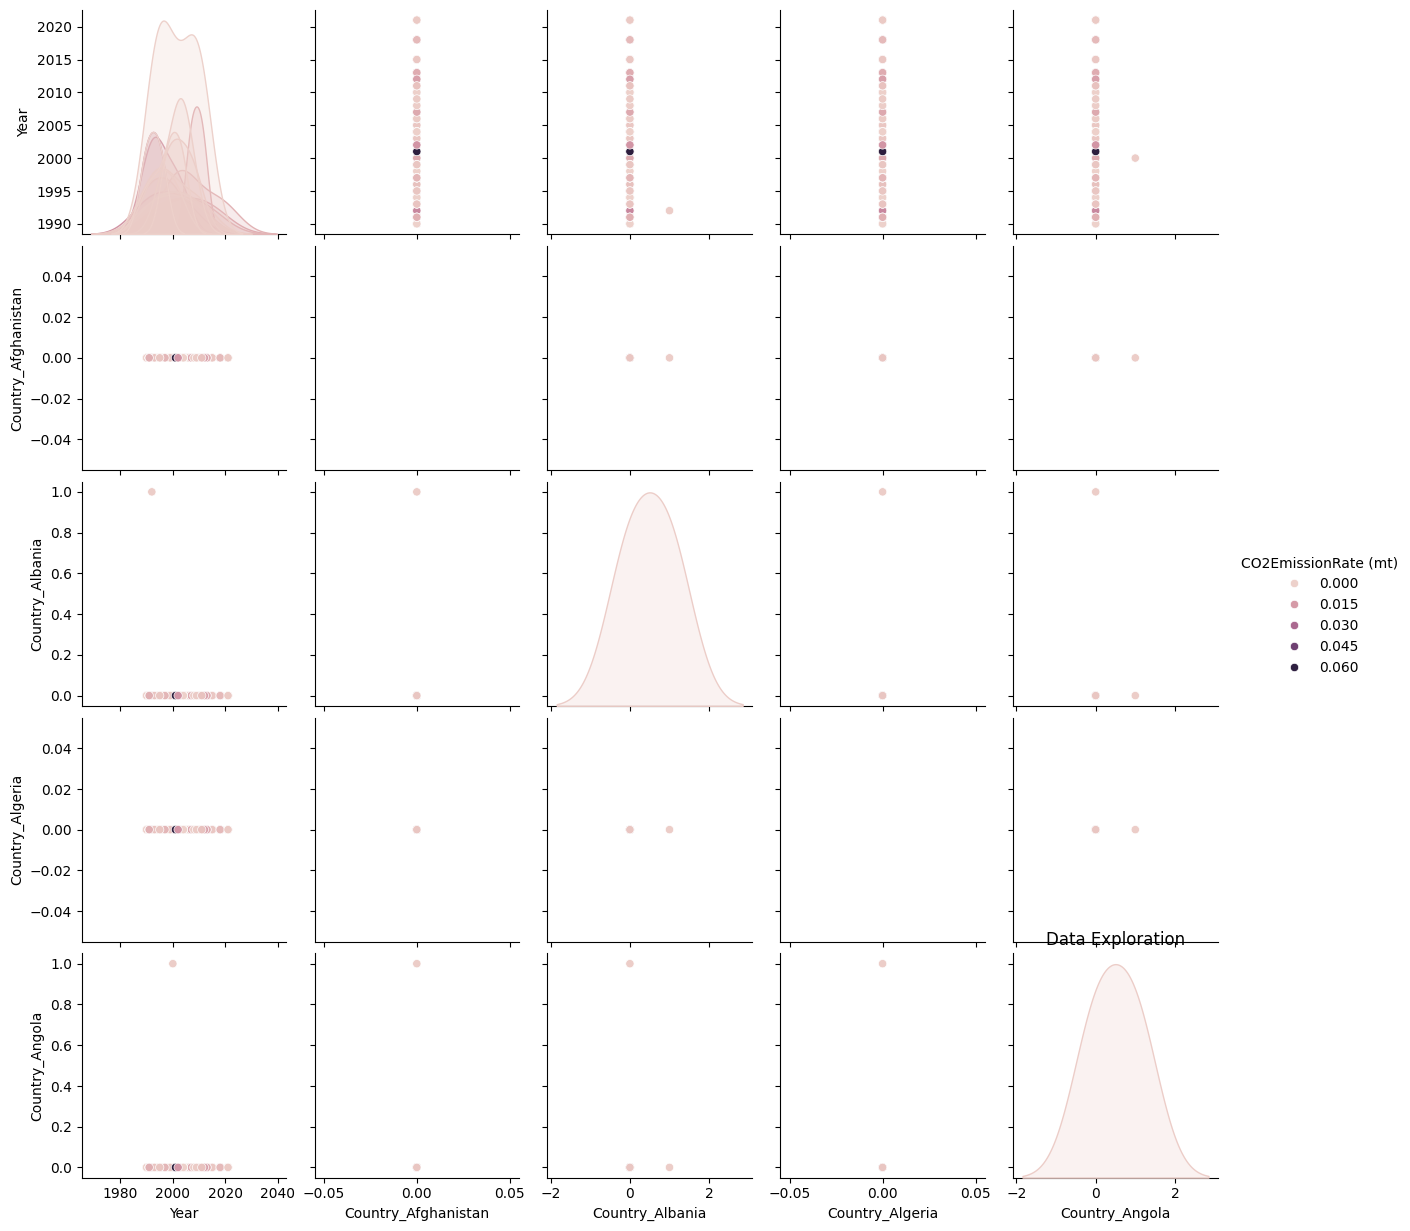

In [15]:
import seaborn as sns
import plotly.express as px

# Data Exploration Plot
sns.pairplot(data.sample(100), vars=X.columns.tolist()[:5], hue='CO2EmissionRate (mt)')
plt.title('Data Exploration')
plt.show()

# Model Evaluation Plot
fig = px.scatter(x=y_test, y=y_pred.flatten(), labels={'x': 'Actual CO2 Emission Rate', 'y': 'Predicted CO2 Emission Rate'},
                 title='Model Evaluation', trendline='ols')
fig.show()




In [16]:
# Model Training History
epochs = list(range(len(history.history['loss'])))  # Convert range to list
fig = px.line(x=epochs, y=history.history['loss'], labels={'x': 'Epoch', 'y': 'Loss'}, title='Training History')
fig.add_scatter(x=epochs, y=history.history['val_loss'], mode='lines', name='Validation Loss')
fig.show()


# Residual Plot
residuals = y_test - y_pred.flatten()
fig = px.scatter(x=y_pred.flatten(), y=residuals, labels={'x': 'Predicted CO2 Emission Rate', 'y': 'Residuals'},
                 title='Residual Plot', trendline='ols')
fig.show()

##**ENERGY SECTOR**

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define a function to find the best k for feature selection
def find_best_k(X, y):
    best_k = None
    best_score = -np.inf
    for k in range(1, X.shape[1] + 1):
        selector = SelectKBest(score_func=f_regression, k=k)
        X_selected = selector.fit_transform(X, y)
        score = np.mean(selector.scores_)
        if score > best_score:
            best_k = k
            best_score = score
    return best_k

# Load the dataset
data = pd.read_csv(r'/content/PJME_hourly.csv')

# Convert the 'Datetime' column to datetime format and set it as the index
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

# Select a subset of the data (e.g., 6,000 rows)
data = data[:6000]

# Feature Engineering: Derive 'dayofweek' and 'hourofday' features
data['dayofweek'] = data.index.dayofweek
data['hourofday'] = data.index.hour

# Preprocess the data
scaler = MinMaxScaler()
data['PJME_MW'] = scaler.fit_transform(data['PJME_MW'].values.reshape(-1, 1))

# Prepare the input and output
X = data.drop(['PJME_MW'], axis=1)  # Features
y = data['PJME_MW']  # Target

# Find the best value of k for feature selection
best_k = find_best_k(X, y)

# Use the best value of k for feature selection
selector = SelectKBest(score_func=f_regression, k=best_k)
X_selected = selector.fit_transform(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Build the ANN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr, checkpoint])

# Evaluate the model
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Energy Dataset ANN Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)


<ipython-input-17-55ecc5565df5>:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-17-55ecc5565df5>:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-17-55ecc5565df5>:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Epoch 1/200
44/60 [=====================>........] - ETA: 0s - loss: 0.9008
Epoch 1: val_loss improved from inf to 0.62693, saving model to best_model.h5
60/60 [==============================] - 2s 6ms/step - loss: 0.8387 - val_loss: 0.6269 - lr: 1.0000e-05
Epoch 2/200
49/60 [=======================>......] - ETA: 0s - loss: 0.5135

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.




Epoch 2: val_loss improved from 0.62693 to 0.35164, saving model to best_model.h5
60/60 [==============================] - 0s 3ms/step - loss: 0.4838 - val_loss: 0.3516 - lr: 1.0000e-05
Epoch 3/200
43/60 [====================>.........] - ETA: 0s - loss: 0.2895
Epoch 3: val_loss improved from 0.35164 to 0.19055, saving model to best_model.h5
60/60 [==============================] - 0s 4ms/step - loss: 0.2672 - val_loss: 0.1905 - lr: 1.0000e-05
Epoch 4/200
46/60 [======================>.......] - ETA: 0s - loss: 0.1512
Epoch 4: val_loss improved from 0.19055 to 0.10409, saving model to best_model.h5
60/60 [==============================] - 0s 4ms/step - loss: 0.1450 - val_loss: 0.1041 - lr: 1.0000e-05
Epoch 5/200
46/60 [======================>.......] - ETA: 0s - loss: 0.0870
Epoch 5: val_loss improved from 0.10409 to 0.06195, saving model to best_model.h5
60/60 [==============================] - 0s 4ms/step - loss: 0.0827 - val_loss: 0.0619 - lr: 1.0000e-05
Epoch 6/200
47/60 [========

In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Visualize the data
fig_data = go.Figure()
fig_data.add_trace(go.Scatter(x=data.index, y=data['PJME_MW'], mode='lines', name='Actual Energy Consumption', line=dict(color='blue')))
fig_data.update_layout(title='Actual Energy Consumption Over Time', xaxis_title='Datetime', yaxis_title='Energy Consumption (Normalized)')
fig_data.show()

# Visualize the selected features
feature_names = X.columns[selector.get_support()]
fig_features = make_subplots(rows=1, cols=2, subplot_titles=('Day of Week', 'Hour of Day'))

for i, feature in enumerate(['dayofweek', 'hourofday']):
    fig_features.add_trace(go.Scatter(x=data.index, y=data[feature], mode='lines', name=feature), row=1, col=i+1)

fig_features.update_layout(title='Selected Features', showlegend=False)
fig_features.show()



In [22]:
# Histogram of Energy Consumption Distribution
fig_hist = go.Figure()
fig_hist.add_trace(go.Histogram(x=data['PJME_MW'], nbinsx=30, marker=dict(color='blue')))
fig_hist.update_layout(title='Distribution of Energy Consumption', xaxis_title='Energy Consumption (Normalized)', yaxis_title='Frequency')
fig_hist.show()

# Correlation Heatmap of Features
correlation_matrix = data[['PJME_MW', 'dayofweek', 'hourofday']].corr()
fig_corr = go.Figure(data=go.Heatmap(z=correlation_matrix.values,
                                      x=correlation_matrix.columns,
                                      y=correlation_matrix.columns,
                                      colorscale='Viridis'))
fig_corr.update_layout(title='Correlation Heatmap of Features', xaxis_title='Features', yaxis_title='Features')
fig_corr.show()





## **FINANCE** **SECTOR**

In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def find_best_k(X, y):
    best_k = None
    best_score = -np.inf
    for k in range(1, X.shape[1] + 1):
        selector = SelectKBest(score_func=f_regression, k=k)
        X_selected = selector.fit_transform(X, y)
        score = np.mean(selector.scores_)
        if score > best_score:
            best_k = k
            best_score = score
    return best_k

# Load the dataset
data = pd.read_csv(r"/content/all_stocks_5yr.csv")

# Convert the 'date' column to datetime format and set it as the index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Drop the 'Name' column
data = data.drop('Name', axis=1)

# Drop non-numeric columns before scaling
numeric_data = data.drop(['close'], axis=1)

# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
scaled_data = imputer.fit_transform(scaled_data)

# Combine scaled numeric data with the 'close' column
scaled_data = pd.DataFrame(scaled_data, columns=numeric_data.columns, index=data.index)
scaled_data['close'] = data['close']

# Prepare the input and output
X = scaled_data.drop(['close'], axis=1)
y = scaled_data['close']

# Split the data into training and testing sets based on time
train_data = scaled_data.iloc[:int(len(scaled_data)*0.8)]  # 80% of the data for training
test_data = scaled_data.iloc[int(len(scaled_data)*0.8):]   # 20% of the data for testing

# Find the best value of k for feature selection
best_k = find_best_k(X, y)

# Use the best value of k for feature selection
selector = SelectKBest(score_func=f_regression, k=best_k)
X_selected = selector.fit_transform(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Build the ANN model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer
])

# Compile the model
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=[early_stopping, reduce_lr, checkpoint])

# Evaluate the model
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Finance Dataset ANN Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2) Score:", r2)


Epoch 1/50
6183/6191 [============================>.] - ETA: 0s - loss: 15995.7109
Epoch 1: val_loss improved from inf to 14705.77832, saving model to best_model.h5
6191/6191 [==============================] - 36s 5ms/step - loss: 15996.7891 - val_loss: 14705.7783 - lr: 1.0000e-05
Epoch 2/50
  29/6191 [..............................] - ETA: 22s - loss: 16569.9180

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



5744/6191 [==========================>...] - ETA: 1s - loss: 12025.7734

KeyboardInterrupt: 